In [1]:
from scipy import stats
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import glob
import json
import networkx as nx
from graphviz import Digraph
import os
os.environ["PATH"] += os.pathsep + 'C:\\graphviz\\bin'

In [2]:
files = glob.glob("dados/*.json")

- Funções:

In [3]:
def height(list_adj, node):
    if(len(list_adj[node]) == 0):
        return 1
    else:
        aux = list()
        for i in list_adj[node]:
            aux.append(height(list_adj, i))
        return max(aux) + 1

In [4]:
def sub_trees(tweet):
    aux_heights = dict()
    for first_replie in tweet:
        try:
            aux_heights[tweet[first_replie]] += 1
        except:
            aux_heights[tweet[first_replie]] = 1
            
        #keys: altura da subarvore
        #values: úmero de árvores com a dada altura
    plt.figure(figsize = (20,10))
    plt.bar(aux_heights.values(), aux_heights.keys(), align='center', alpha=0.5)
    plt.xlabel('Número de subarvores com a altura y')
    plt.ylabel('Altura da subarvore')
    plt.title('Distribuição das alturas das subárvores do tweet')
    plt.xticks(range(0,max(aux_heights.values()) + 1, 20))
    plt.savefig("image.png", quality = 95, orientation='portrait')

In [5]:
def depth(file, leaf):
    depth = 0;
    up = leaf;
    while(graphs[file].nodes[up]['replie_to'] is not None): 
        up = graphs[file].nodes[up]['replie_to']
        depth += 1
    return depth

- Criando um grafo como estrutura de dados (lista de adjacências de um nó é composta pelos nós a que ele responde):

In [6]:
graphs = dict()
for filename in files:
    DG = nx.DiGraph()
    with open(filename, 'r', encoding="utf8") as f: 
        data = json.load(f)
        for tweet in data:
            DG.add_node(tweet)
            if(data[tweet]['replie_to'] is not None):
                DG.add_node(data[tweet]['replie_to'])
                DG.add_edge(tweet,data[tweet]['replie_to'])
            for attr in data[tweet]:
                DG.node[tweet][attr] = data[tweet][attr]
    graphs[filename] = DG

- Lista de adjacências do sentido oposto (lista de adjacências de um nó é composta pelos nós que respondem a ele):

In [7]:
opp_adjacency = dict()
for each in graphs:
    list_adj = dict()
    for item in graphs[each]:
        try:
            list_adj[item]
        except:
            list_adj[item] = list()
        if (graphs[each].nodes[item]['replie_to'] is not None):
            try:
                list_adj[graphs[each].nodes[item]['replie_to']].append(item)
            except:
                list_adj[graphs[each].nodes[item]['replie_to']] = list()
                list_adj[graphs[each].nodes[item]['replie_to']].append(item)
    opp_adjacency[each] = list_adj 

- Número total de Tweets:

In [8]:
size = 0
for each in graphs:
    size += len(graphs[each])
size

48413

- Distribuição do tamanho das florestas:

In [9]:
size_forests = dict()
for each in graphs:
    fa = each.split("_")
    fa = fa[1].split(".")
    try:
        size_forests[fa[0]] += len(graphs[each])
    except:
        size_forests[fa[0]] = len(graphs[each])

In [10]:
np_forests = np.array(tuple(size_forests.values()))

In [11]:
ecdf = ECDF(np_forests)

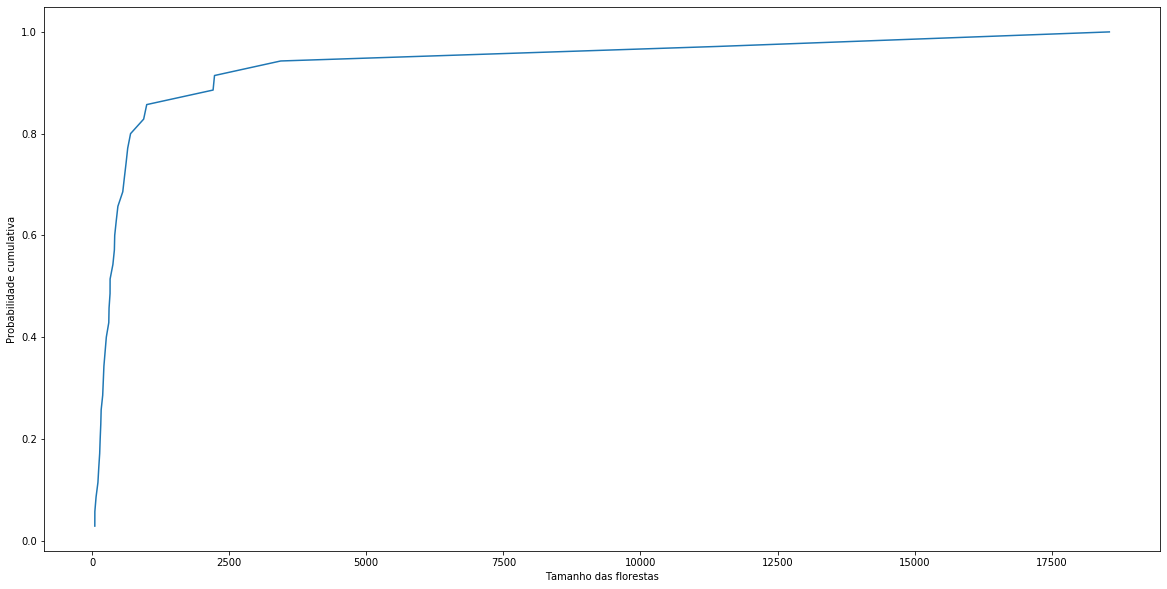

In [12]:
_= plt.figure(figsize = (20,10))
_= plt.plot(ecdf.x, ecdf.y)
_= plt.xlabel("Tamanho das florestas")
_= plt.ylabel("Probabilidade cumulativa")
_= plt.savefig("dist_forests.png", quality = 95, orientation='portrait')

- Cálculo de dimensões:

In [13]:
#Altura de cada árvore
main_height = dict()
sec_height = dict()
for each in graphs:
    fa = each.split("_")
    node = fa[len(fa)-1].split(".")
    if(len(fa) == 2):
        main_height[each] = height(opp_adjacency[each], node[0])
    else:
        sec_height[each] = height(opp_adjacency[each], node[0])

In [14]:
#Altura das primeiras respostas
main_sub = dict()
sec_sub = dict()
for each in graphs:
    fa = each.split("_")
    node = fa[len(fa)-1].split(".")
    sub_aux = dict()
    for item in graphs[each]:
        if (graphs[each].nodes[item]['replie_to'] == node[0]):
            sub_aux[item] = height(opp_adjacency[each], item)
    if(len(fa) == 2):
        main_sub[each] = sub_aux
    else:
        sec_sub[each] = sub_aux

In [15]:
#Fator de ramificação de cada árvore
main_branch = dict()
sec_branch = dict()
for each in graphs:
    fa = each.split("_")
    branching_factor = dict()
    for item in graphs[each]:
        if(graphs[each].nodes[item]['replie_to'] is not None):
            try:
                branching_factor[graphs[each].nodes[item]['replie_to']] = branching_factor[graphs[each].nodes[item]['replie_to']] + 1
            except:
                branching_factor[graphs[each].nodes[item]['replie_to']] = 1
    if(len(fa) == 2):
        try:
            main_branch[each] = max([i for i in branching_factor.values()]) 
        except:
            main_branch[each] = 0
    else:
        try:
            sec_branch[each] = max([i for i in branching_factor.values()]) 
        except:
            sec_branch[each] = 0

In [16]:
#Número de filhos de cada nó
descendents = dict()
for tree in opp_adjacency:
    np_descendents = np.empty((0,1))
    for item in opp_adjacency[tree]:
        np_descendents = np.append(np_descendents, len(opp_adjacency[tree][item]))
    descendents[tree] = np_descendents

In [19]:
ecdf_original = ECDF(descendents['dados/replies_238717783007977473.json'])
ecdf_quote = ECDF(descendents['dados/replies_238717783007977473_1032709192002486272.json'])

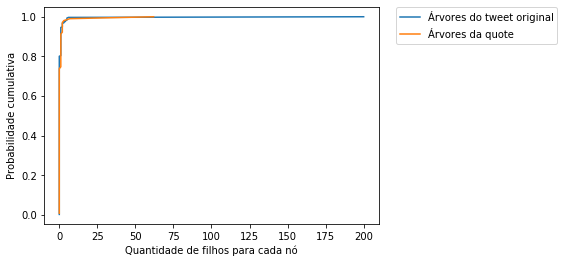

In [20]:
_= plt.plot(ecdf_original.x, ecdf_original.y, label="Árvores do tweet original")
_= plt.plot(ecdf_quote.x, ecdf_quote.y, label="Árvores da quote")
_= plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
_= plt.xlabel("Quantidade de filhos para cada nó")
_= plt.ylabel("Probabilidade cumulativa")

In [21]:
#Profundidade das folhas
graph_depths = dict()
for each in opp_adjacency:
    graph_depths[each] = dict()
    for item in opp_adjacency[each]:
        if(len(opp_adjacency[each][item]) == 0):
            graph_depths[each][item] = depth(each,item)

In [22]:
long_quote = "dados/replies_238717783007977473_1135976422046986240.json"
degenerated_quote = "dados/replies_238717783007977473_1032709192002486272.json" 
large_quote = "dados/replies_238717783007977473_758826494969786368.json" 
quotes_trump = [long_quote, degenerated_quote, large_quote]

In [23]:
long_ecdf = ECDF(np.array(tuple(graph_depths[long_quote].values())))
degenerated_ecdf = ECDF(np.array(tuple(graph_depths[degenerated_quote].values())))
large_ecdf = ECDF(np.array(tuple(graph_depths[large_quote].values())))

In [24]:
g = Digraph('G')
g.attr(size='20')
for quote in quotes_trump:
    with open(quote, 'r', encoding="utf8") as f:
        data = json.load(f)
    g.attr('node')
    for key in data:
        g.node(key)
    for key in data:
        if(key is not None):
            if(data[key]["replie_to"] is not None):
                g.edge(data[key]["replie_to"], key)
g.view()

'G.gv.pdf'

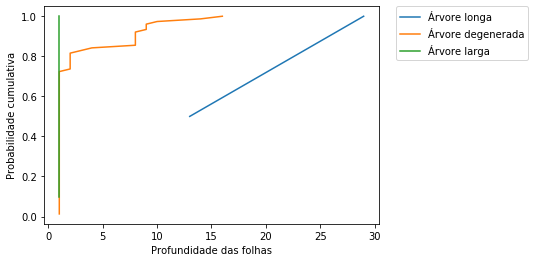

In [25]:
_= plt.plot(long_ecdf.x, long_ecdf.y, label="Árvore longa")
_= plt.plot(degenerated_ecdf.x, degenerated_ecdf.y, label="Árvore degenerada")
_= plt.plot(large_ecdf.x, large_ecdf.y, label="Árvore larga")
_= plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
_= plt.xlabel("Profundidade das folhas")
_= plt.ylabel("Probabilidade cumulativa")

- Distribuição de altura de um exemplo das árvores primárias:

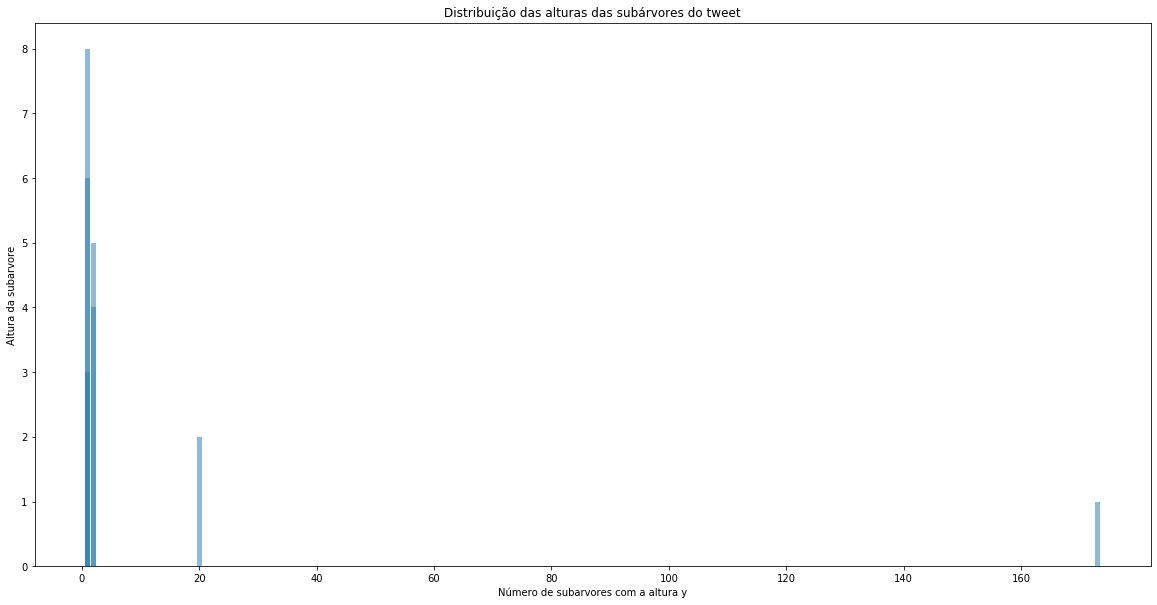

In [26]:
sub_trees(main_sub['dados/replies_238717783007977473.json'])

- Distribuição de altura de um exemplo das árvores secundárias:

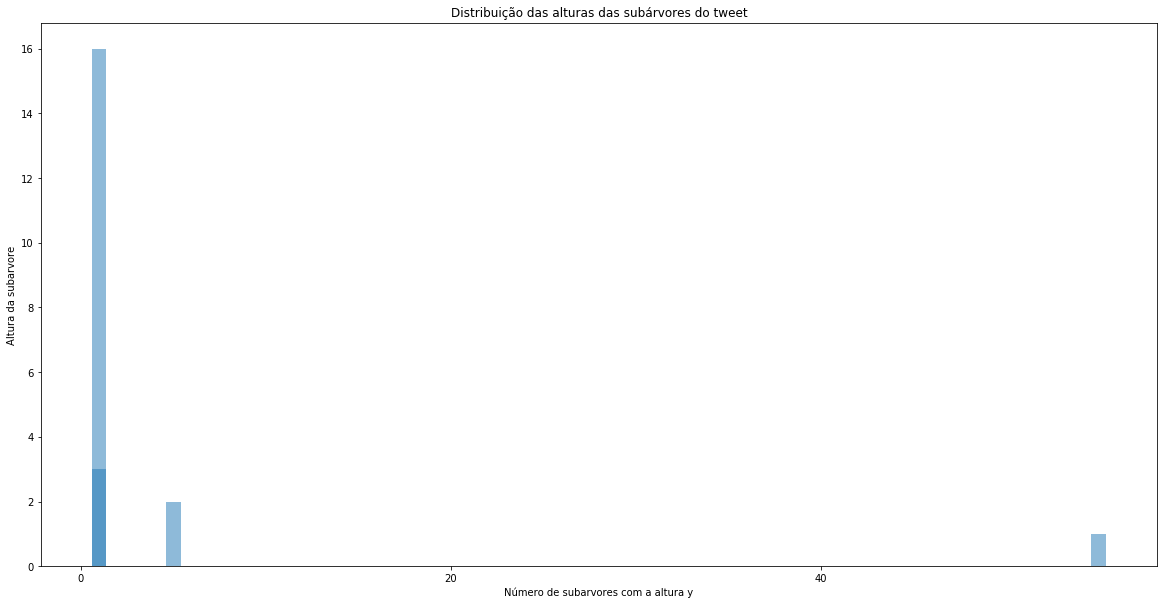

In [27]:
sub_trees(sec_sub['dados/replies_238717783007977473_1032709192002486272.json'])

In [28]:
np_mbranch = np.array(tuple(main_branch.values()))
np_sbranch = np.array(tuple(sec_branch.values()))

In [29]:
ecdf_mbranch = ECDF(np_mbranch)
ecdf_sbranch = ECDF(np_sbranch)

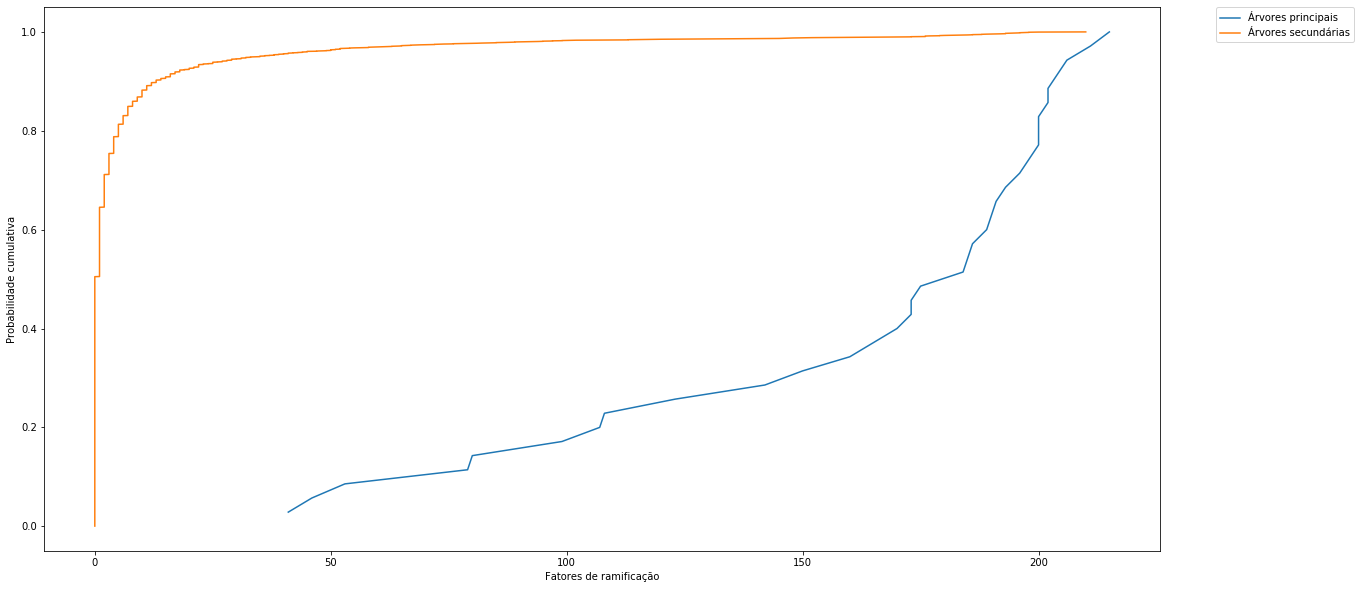

In [30]:
_= plt.figure(figsize = (20,10))
_= plt.plot(ecdf_mbranch.x, ecdf_mbranch.y, label="Árvores principais")
_= plt.plot(ecdf_sbranch.x, ecdf_sbranch.y, label="Árvores secundárias")
_= plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
_= plt.xlabel("Fatores de ramificação")
_= plt.ylabel("Probabilidade cumulativa")
_= plt.savefig("dist_rami.png", quality = 95, orientation='portrait')

- Distribuição dos tempos de resposta:

In [31]:
#se aumentar a base de dados, rodar o arquivo  response_time.py antes
arr = []
for each in graphs:
    for item in graphs[each]:
        arr.append(graphs[each].nodes[item]['response_time'])     

In [32]:
np_responses = np.array(arr)

In [33]:
ecdf_responses = ECDF(np_responses)

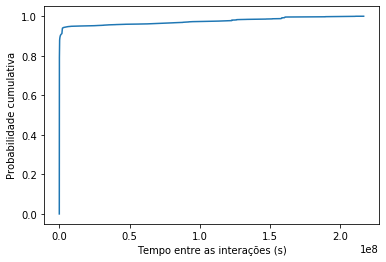

In [34]:
_= plt.plot(ecdf_responses.x, ecdf_responses.y)
_= plt.xlabel("Tempo entre as interações (s)")
_= plt.ylabel("Probabilidade cumulativa")

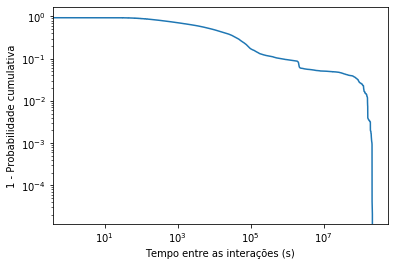

In [35]:
_= plt.plot(ecdf_responses.x, 1 - ecdf_responses.y)
_= plt.xlabel("Tempo entre as interações (s)")
_= plt.ylabel("1 - Probabilidade cumulativa")
plt.xscale('log')
plt.yscale('log')

- Distribuição do número de usuários diferentes em cada árvore:

In [36]:
main_users = dict()
sec_users = dict()
for each in graphs:
    fa = each.split("_")
    different_users = dict()
    for item in graphs[each]:
        try:
            different_users[graphs[each].nodes[item]['user_id']] += 1
        except:
            different_users[graphs[each].nodes[item]['user_id']] = 1
        if(len(fa) == 2):
            main_users[each] = len(different_users)
        else:
            sec_users[each] = len(different_users)        

In [37]:
np_musers = np.array(tuple(main_users.values()))
np_susers = np.array(tuple(sec_users.values()))

In [38]:
ecdf_musers = ECDF(np_musers)
ecdf_susers = ECDF(np_susers)

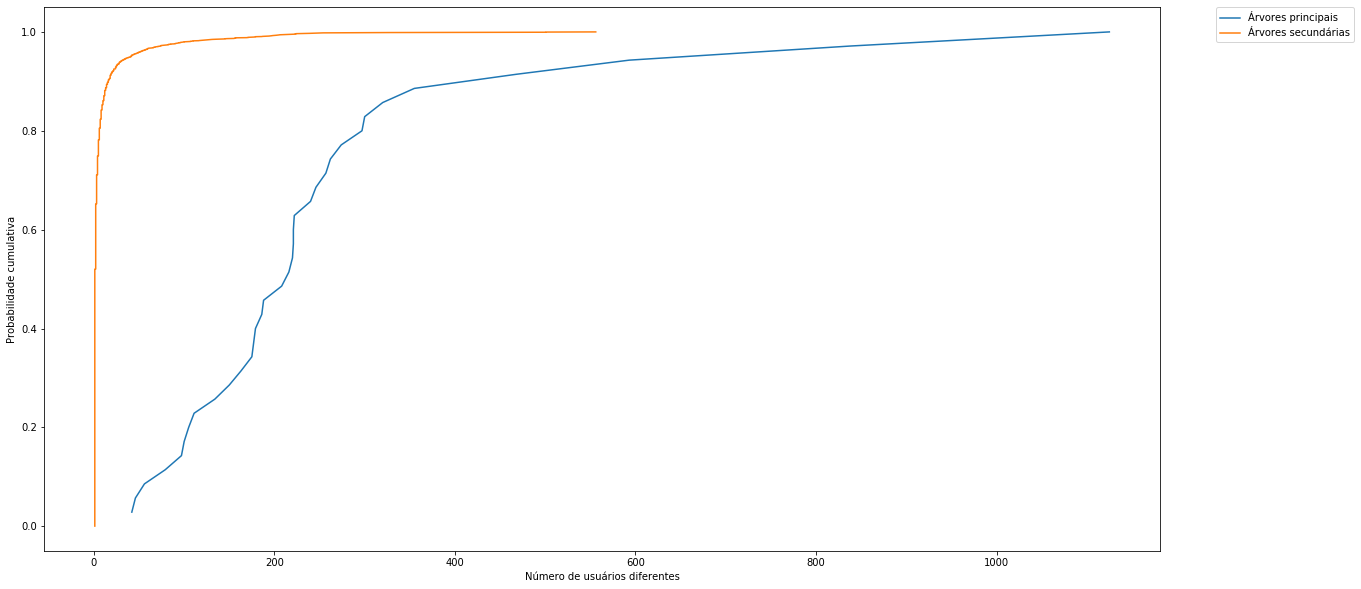

In [39]:
_= plt.figure(figsize = (20,10))
_= plt.plot(ecdf_musers.x, ecdf_musers.y, label="Árvores principais")
_= plt.plot(ecdf_susers.x, ecdf_susers.y, label="Árvores secundárias")
_= plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
_= plt.xlabel("Número de usuários diferentes")
_= plt.ylabel("Probabilidade cumulativa")
_= plt.savefig("dist_users.png", quality = 95, orientation='portrait')